In [1]:
!conda info --envs
!nvidia-smi

# conda environments:
#
base                     /home/sunghyunahn/anaconda3
adwg                     /home/sunghyunahn/anaconda3/envs/adwg
dvaa                  *  /home/sunghyunahn/anaconda3/envs/dvaa
unetr_pp                 /home/sunghyunahn/anaconda3/envs/unetr_pp

Thu Oct  5 17:03:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:01:00.0 Off | 

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import cv2

from torch import nn
from torch import Tensor
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from pytorch_model_summary import summary
import torch.nn.init as init
from timm.models.layers import trunc_normal_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


### Image Functions

In [3]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    '''
    input: tensor [c, h, w]
    '''
    img = img * 0.5 + 0.5     # unnormalize
    plt.figure(figsize=(5,5))   
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()
    plt.close()
    return img

# 이미지 패치로 나누는 함수
def split_image_into_patches(image, patch_size):
    '''
    input: tensor [c, h, w]
    '''
    _, height, width = image.shape
    patch_height, patch_width = (patch_size, patch_size)

    patch_list = []
    for i in range(0, height, patch_height):
        for j in range(0, width, patch_width):
            patch = image[:, i:i+patch_height, j:j+patch_width]
            patch_list.append(patch)

    patches = torch.stack(patch_list, dim=0) # num x c x h x w

    return patches

### Dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1, 3, 32, 32])


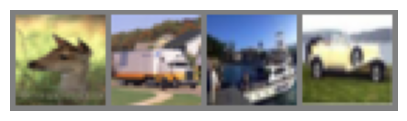

deer  truck ship  car  


In [24]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]

# 한 이미지(x) shape 확인하기
x = images[0]
x = x.unsqueeze(0) # add batch dim
print(x.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

### Architecture

Patch Embedding

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 8, emb_size: int = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

(check)

torch.Size([1, 3, 32, 32])


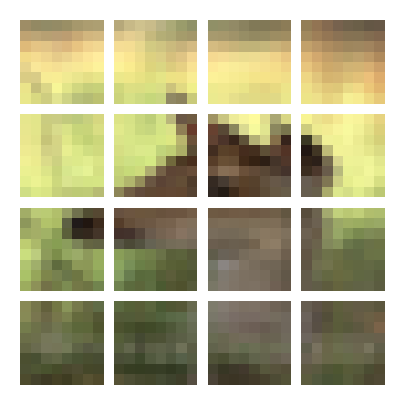

torch.Size([1, 16, 128])

In [25]:
print(x.shape) # image

x_patches = split_image_into_patches(x.squeeze(0), patch_size=8)  
imshow(torchvision.utils.make_grid(x_patches, nrow=4, ncolumn=4, padding=1, pad_value=1)) # patches

PatchEmbedding(patch_size=8)(x).shape # embedded

Patch Embedding (w CLS token, pos_encoding)

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, img_size: int = 32, patch_size: int = 8, emb_size: int = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        
        # cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size)) # [1, 1, d]
        # pos encoding
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size)) # [hw, d]
                
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x) # [b, hw, d]
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b) # [b, 1, d]

        x = torch.concat([cls_tokens, x], dim=1) # [b, hw+1, d]
        x += self.positions
        return x

(check)

In [33]:
PatchEmbedding(patch_size=8)(x).shape

torch.Size([1, 17, 128])

Multi-Head Attention

In [6]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_size: int = 128, num_heads: int = 4, dropout: float = 0):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = emb_size
        self.head_dim = int(emb_size / num_heads)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        q = self.query(x) # [b, n, d], n=hw+1
        k = self.key(x)
        v = self.value(x)
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3) # [b, h, n, d/h]
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,3,1) # k.t
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)

        scaling = self.head_dim ** (1/2)
        attention = torch.softmax(q @ k / scaling, dim=-1) # [b, h, n, n]
        x = self.dropout(attention) @ v # [b, h, n, d/h]
        x = x.permute(0,2,1,3).reshape(batch_size, -1, self.embed_dim) # [b, n, d]

        return x, attention

Residual Add

In [7]:
class ResidualAdd1(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        res = x
        x, attention = self.fn(x)
        x += res
        return x, attention

In [8]:
class ResidualAdd2(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        res = x
        x = self.fn(x)
        x += res
        return x

MLP

In [9]:
class MLP(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
    
    def forward(self, x):
        return self.mlp(x)

Transformer Encoder

In [10]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 128,
                 drop_p = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__()

        self.work1 = ResidualAdd1(nn.Sequential(
                                nn.LayerNorm(emb_size),
                                MultiheadAttention(emb_size, **kwargs)))
        self.work2 = ResidualAdd2(nn.Sequential(
                                nn.LayerNorm(emb_size),
                                MLP(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                                nn.Dropout(drop_p)))
        
    def forward(self, x):
        x, attention = self.work1(x)
        x = self.work2(x)
        return x, attention

(check)

In [39]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded)[0].shape

torch.Size([1, 17, 128])

Vision Transformer (ViT)

In [11]:
class VisionTransformer(nn.Sequential):
    def __init__(self, patch_size: int = 8, emb_size: int = 128, num_layers: int = 12, num_heads: int = 4, n_classes: int = 10):
        super().__init__()
        self.patchembedding = PatchEmbedding(patch_size=patch_size, emb_size=emb_size)
        self.transformer = nn.ModuleList([TransformerEncoderBlock(emb_size=emb_size, num_heads=num_heads) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(nn.LayerNorm(emb_size),
                                      nn.Linear(emb_size, n_classes))

    def forward(self, x):
        x = self.patchembedding(x)
        for layer in self.transformer:
            x, attention = layer(x)
        x = self.mlp_head(x[:,0])
        return x, attention

(check)

In [41]:
model = VisionTransformer()
print('input:',x.shape)
print('output:',model(x)[0].shape)

input: torch.Size([1, 3, 32, 32])
output: torch.Size([1, 10])


### Training

In [13]:
patch_size = 8
emb_size = 128
num_layers = 12
n_classes = 10
num_heads = 4
num_epochs = 100
SAVE_PATH = './cifar_vit.pth'

In [19]:
def weights_init(m):
    if isinstance(m, (nn.Linear)):
        trunc_normal_(m.weight, std=.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.LayerNorm)):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

In [20]:
# load model
net = VisionTransformer(patch_size=patch_size,
                        emb_size=emb_size,
                        num_layers=num_layers,
                        n_classes=n_classes,
                        num_heads=num_heads).to(device)
net.apply(weights_init)

# load loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

tr_losses = []
val_losses = []
best_epoch = 0

# training
for epoch in range(num_epochs):
    train_sum_loss = 0
    val_sum_loss = 0   
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_sum_loss += loss.item()

    # record train loss
    tr_loss = train_sum_loss / len(trainloader)
    tr_losses.append(tr_loss)
    print('[%d/%d] Train CE Loss: %.4f\t'% (epoch+1, num_epochs, tr_loss))

    # validation per one epoch
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        val_sum_loss += loss.item()

    # early stopping
    val_loss = val_sum_loss / len(testloader)
    if epoch > 10:
        if val_loss < min(val_losses):
            best_epoch = epoch
            torch.save(net.state_dict(), SAVE_PATH)
            print('--------------------------------Best model save at [%d] epoch!' % (epoch+1))
    
    # record validation loss
    val_losses.append(val_loss)
    print('[%d/%d] Valiation CE Loss: %.4f\t'% (epoch+1, num_epochs, val_loss))

print('Finished Training')

[1/100] Train CE Loss: 2.2929	
[1/100] Valiation CE Loss: 2.2682	
[2/100] Train CE Loss: 2.2059	
[2/100] Valiation CE Loss: 2.1213	
[3/100] Train CE Loss: 2.0947	
[3/100] Valiation CE Loss: 2.0733	
[4/100] Train CE Loss: 2.0758	
[4/100] Valiation CE Loss: 2.0634	
[5/100] Train CE Loss: 2.0677	
[5/100] Valiation CE Loss: 2.0574	
[6/100] Train CE Loss: 2.0607	
[6/100] Valiation CE Loss: 2.0492	
[7/100] Train CE Loss: 2.0539	
[7/100] Valiation CE Loss: 2.0397	
[8/100] Train CE Loss: 2.0418	
[8/100] Valiation CE Loss: 2.0235	
[9/100] Train CE Loss: 2.0233	
[9/100] Valiation CE Loss: 2.0079	
[10/100] Train CE Loss: 2.0100	
[10/100] Valiation CE Loss: 1.9924	
[11/100] Train CE Loss: 1.9989	
[11/100] Valiation CE Loss: 1.9832	
[12/100] Train CE Loss: 1.9899	
--------------------------------Best model save at [12] epoch!
[12/100] Valiation CE Loss: 1.9739	
[13/100] Train CE Loss: 1.9808	
--------------------------------Best model save at [13] epoch!
[13/100] Valiation CE Loss: 1.9639	
[14/100]

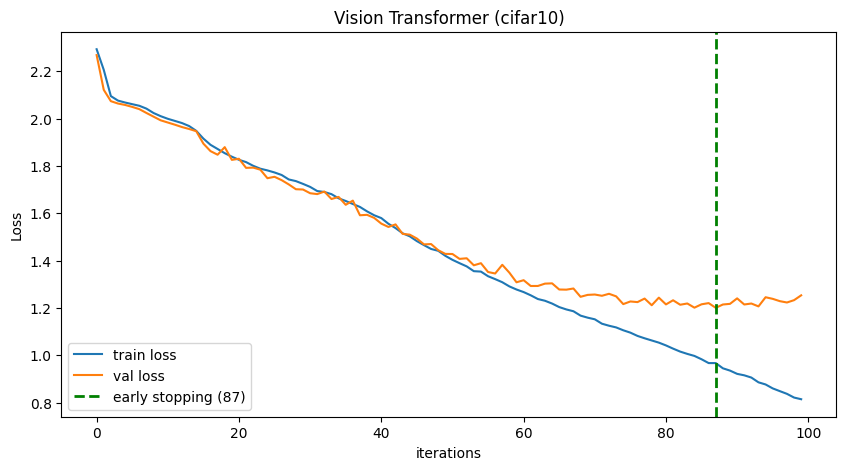

In [21]:
plt.figure(figsize=(10,5))
plt.title("Vision Transformer (cifar10)")
plt.plot(tr_losses,label="train loss")
plt.plot(val_losses,label="val loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch})")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [14]:
patch_size = 8
emb_size = 128
num_layers = 12
n_classes = 10
num_heads = 4
num_epochs = 100
SAVE_PATH = './cifar_vit.pth'

net = VisionTransformer(patch_size=patch_size,
                        emb_size=emb_size,
                        num_layers=num_layers,
                        n_classes=n_classes,
                        num_heads=num_heads).to(device)

try:
    net.load_state_dict(torch.load(SAVE_PATH))
    print('load model ok!')
except:
    print('error')

load model ok!


Inference

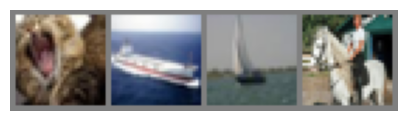

predicted:
cat ship ship dog
label:
cat ship ship horse


In [82]:
# 테스트용 이미지를 무작위로 가져오기
dataiter = iter(testloader)
images, labels = next(dataiter)

i = torch.randint(1, 101, (1,)).item()
images = images[i:i+4].to(device)
labels = labels[i:i+4].to(device)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images.cpu()))

# 예측(perdicted) 출력
outputs, _ = net(images)
_, predicted = torch.max(outputs.data, 1)
print('predicted:',sep=' ')
print(' '.join(f'{classes[predicted[j]]}' for j in range(4)))
    
# 정답(label) 출력
print('label:',sep=' ')
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

Attention Visualization

Text(0.5, -0.15, 'Attentioned')

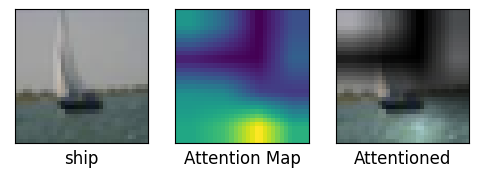

In [83]:
# 이미지 시각화 
num = 2
img = images[num].to(device)
show_img = (img*0.5+0.5).cpu().permute(1,2,0)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 5, 1)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(show_img)
ax.text(0.5, -0.15, f'{classes[predicted[num]]}', transform=ax.transAxes, fontsize=12, ha='center')


# 어텐션 맵 시각화
output, attention = net(img.unsqueeze(0)) # [1, h, n, n]

sum_heatmap = np.zeros(shape=(32,32), dtype=np.float32) 
for i in range(num_heads): 
    attn_heatmap = attention[0, i, 0, 1:].reshape((4, 4)).detach().cpu().numpy() # cls_token row of attn map
    attn_heatmap = cv2.resize(attn_heatmap,(32,32))
    sum_heatmap += attn_heatmap
avg_heatmap = sum_heatmap / num_heads
avg_heatmap = (avg_heatmap - avg_heatmap.min()) / (avg_heatmap.max() - avg_heatmap.min())

ax = fig.add_subplot(1, 5, 2)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(avg_heatmap)
ax.text(0.5, -0.15, 'Attention Map', transform=ax.transAxes, fontsize=12, ha='center')


# 어텐션된 이미지 시각화
attn_img = show_img.clone().detach()
attn_img[:,:,0] = (attn_img[:,:,0]*avg_heatmap)*2
attn_img[:,:,1] = (attn_img[:,:,1]*avg_heatmap)*2
attn_img[:,:,2] = (attn_img[:,:,2]*avg_heatmap)*2

ax = fig.add_subplot(1, 5, 3)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(attn_img)
ax.text(0.5, -0.15, 'Attentioned', transform=ax.transAxes, fontsize=12, ha='center')

Evaluation

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %
